In [220]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
# Load data
ground_truth = pd.read_csv("../source_data/test_preprocess.csv")
train_data = pd.read_csv("../source_data/train_preprocess.csv")
predictions = {
    "SVM": pd.read_csv('../evaluation/svm_predictions.csv'),
    "IndoBERT": pd.read_csv('../evaluation/bert_predictions.csv'),
    # zero-shot models
    "GPT-3.5 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4o_predictions.csv'),
    # few-shot models
    "GPT-3.5 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4o_predictions.csv'),
}

# Configuration
aspect_keys = ["ac", "air_panas", "bau", "general", "kebersihan", 
               "linen", "service", "sunrise_meal", "tv", "wifi"]

In [222]:
def evaluate_model(true_df, pred_df, model_name):
    """Core evaluation function for a single model"""
    merged = true_df.merge(pred_df, on="review", suffixes=('_true', '_pred'))
    results = []
    
    for aspect in aspect_keys:
        y_true = merged[f"{aspect}_true"]
        y_pred = merged[f"{aspect}_pred"]
        
        report = classification_report(y_true, y_pred, 
                                      target_names=['neg', 'pos', 'neut'],
                                      output_dict=True)
        
        results.append({
            'model': model_name,
            'aspect': aspect,
            'accuracy': accuracy_score(y_true, y_pred),
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'neg_precision': report['neg']['precision'],
            'neg_recall': report['neg']['recall'],
            'neg_f1': report['neg']['f1-score'],
            'pos_precision': report['pos']['precision'],
            'pos_recall': report['pos']['recall'],
            'pos_f1': report['pos']['f1-score'],
            'neut_precision': report['neut']['precision'],
            'neut_recall': report['neut']['recall'],
            'neut_f1': report['neut']['f1-score'],
            'support': report['weighted avg']['support']
        })
    
    return pd.DataFrame(results)

# Main evaluation pipeline
all_results = []
for model_name, pred_df in predictions.items():
    print(f"Evaluating {model_name}...")
    model_results = evaluate_model(ground_truth, pred_df, model_name)
    all_results.append(model_results)

# Generate key outputs
full_results = pd.concat(all_results, ignore_index=True)

Evaluating SVM...
Evaluating IndoBERT...
Evaluating GPT-3.5 Turbo Zero-Shot...
Evaluating GPT-4 Turbo Zero-Shot...
Evaluating GPT-4o Zero-Shot...
Evaluating GPT-3.5 Turbo Few-Shot...
Evaluating GPT-4 Turbo Few-Shot...
Evaluating GPT-4o Few-Shot...


In [223]:
# 1. Model Comparison Table
model_comparison = full_results.groupby('model').agg({
    'accuracy': 'mean',
    'macro_precision': 'mean',
    'macro_recall': 'mean',
    'macro_f1': 'mean',
    'weighted_precision': 'mean',
    'weighted_recall': 'mean',
    'weighted_f1': 'mean',
    'neg_precision': 'mean',
    'neg_recall': 'mean',
    'neg_f1': 'mean',
    'pos_precision': 'mean',
    'pos_recall': 'mean',
    'pos_f1': 'mean',
    'neut_precision': 'mean',
    'neut_recall': 'mean',
    'neut_f1': 'mean',
    'support': 'mean'
}).reset_index()

print("\n=== AVG Model Comparison ===")
model_comparison.round(4)


=== AVG Model Comparison ===


,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,neg_precision,neg_recall,neg_f1,pos_precision,pos_recall,pos_f1,neut_precision,neut_recall,neut_f1,support
0,GPT-3.5 Turbo Few-Shot,0.9143,0.7927,0.7885,0.7765,0.9161,0.9143,0.9133,0.7834,0.7344,0.7354,0.9370,0.9543,0.9453,0.6578,0.6767,0.6489,286.0
1,GPT-3.5 Turbo Zero-Shot,0.9042,0.7804,0.7316,0.7462,0.9005,0.9042,0.8989,0.7842,0.6592,0.7081,0.9183,0.9649,0.9405,0.6387,0.5706,0.5901,286.0
2,GPT-4 Turbo Few-Shot,0.9500,0.8548,0.8643,0.8470,0.9552,0.9500,0.9503,0.8584,0.8255,0.8301,0.9642,0.9736,0.9681,0.7419,0.7937,0.7427,286.0
3,GPT-4 Turbo Zero-Shot,0.9427,0.8337,0.8724,0.8384,0.9508,0.9427,0.9442,0.8371,0.8454,0.8186,0.9640,0.9637,0.9629,0.7001,0.8082,0.7336,286.0
4,GPT-4o Few-Shot,0.9612,0.8714,0.8685,0.8621,0.9620,0.9612,0.9603,0.9085,0.8098,0.8499,0.9679,0.9848,0.9760,0.7378,0.8109,0.7603,286.0
5,GPT-4o Zero-Shot,0.9175,0.8415,0.7011,0.7485,0.9177,0.9175,0.9103,0.8964,0.6233,0.7291,0.9123,0.9884,0.9479,0.7157,0.4917,0.5686,286.0
6,IndoBERT,0.9608,0.8129,0.8093,0.8060,0.9595,0.9608,0.9595,0.8238,0.8362,0.8269,0.9787,0.9761,0.9774,0.6363,0.6155,0.6136,286.0
7,SVM,0.9350,0.7000,0.6718,0.6724,0.9293,0.9350,0.9305,0.7453,0.7450,0.7435,0.9583,0.9741,0.9660,0.3962,0.2965,0.3077,286.0


# Viz

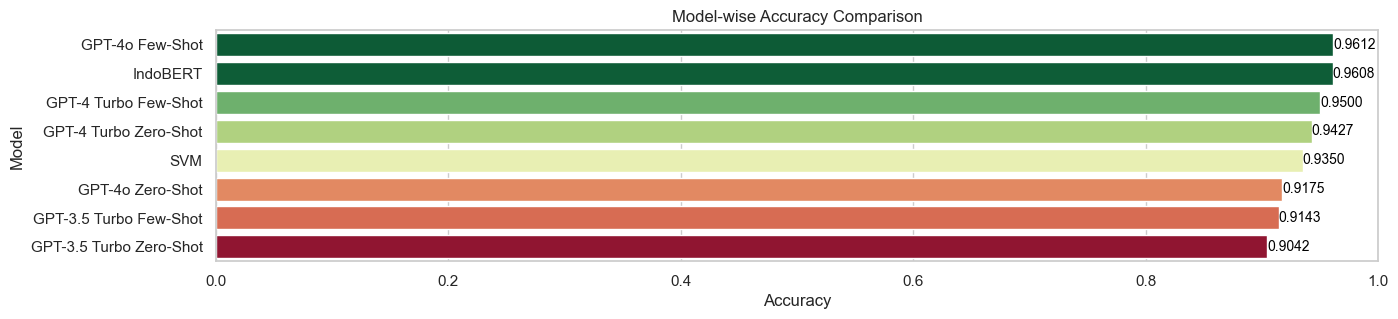

In [224]:
# 1. Model-wise Accuracy Comparison
sns.set_theme(style="whitegrid")
model_comparison = model_comparison.sort_values("accuracy", ascending=False)
norm = plt.Normalize(model_comparison["accuracy"].min(), model_comparison["accuracy"].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
colors = [sm.to_rgba(val) for val in model_comparison["accuracy"]]
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(data=model_comparison, x="accuracy", y="model", palette=colors, ax=ax)

# Annotate bars with accuracy values
for p in ax.patches:
    ax.annotate(f"{p.get_width():.4f}",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Model-wise Accuracy Comparison")
ax.set_xlim(0, 1)
plt.show()

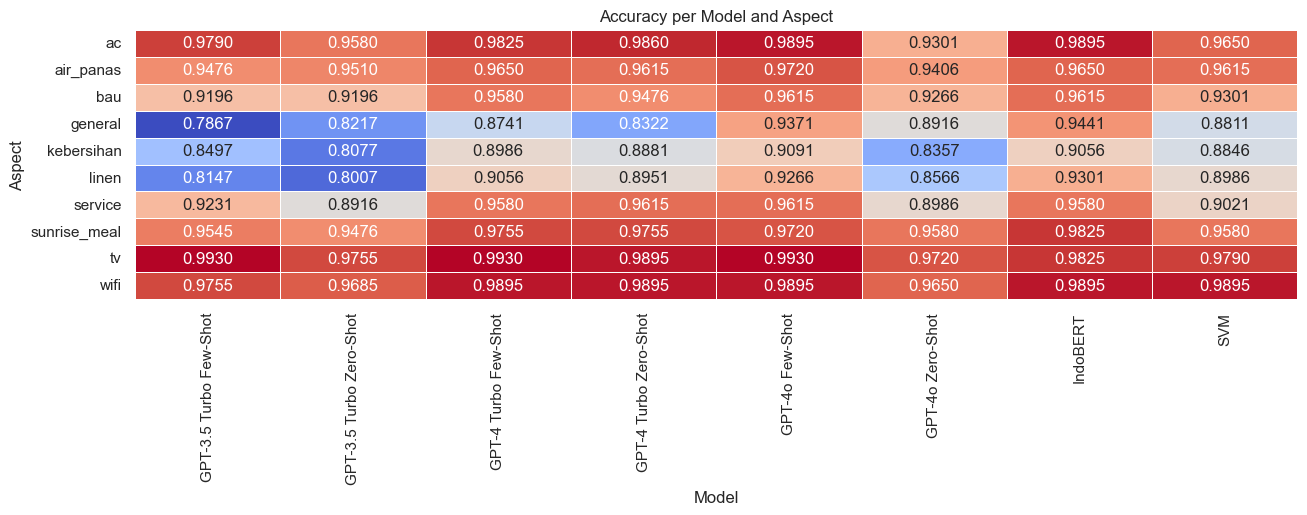

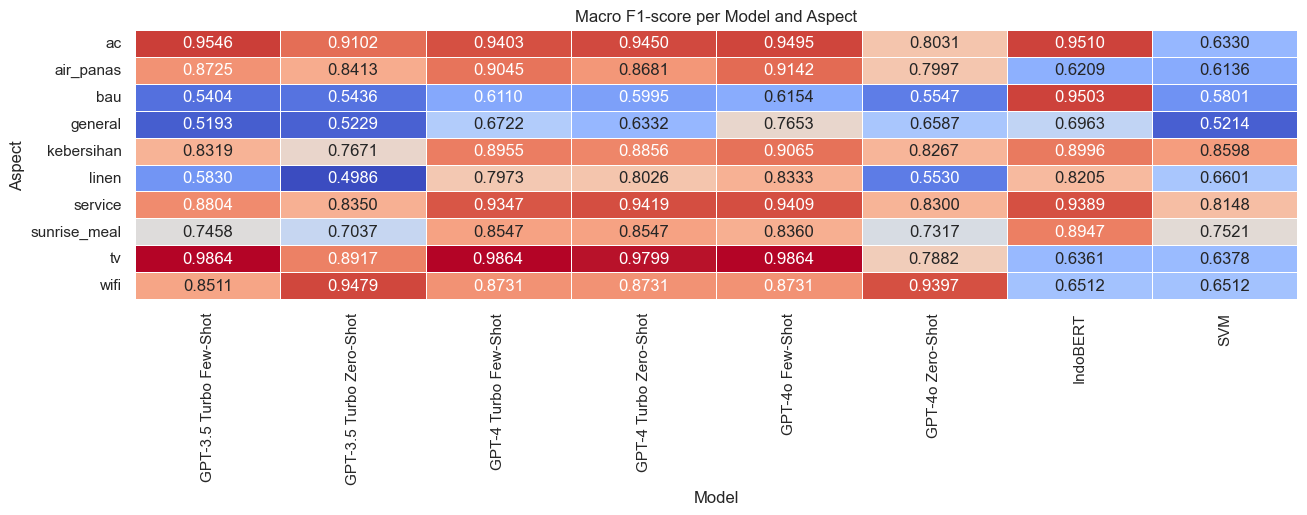

In [225]:
# 2. Heatmap for Macro Accuracy & F1-score per Model and Aspect
plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="accuracy", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Accuracy per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="macro_f1", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Macro F1-score per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

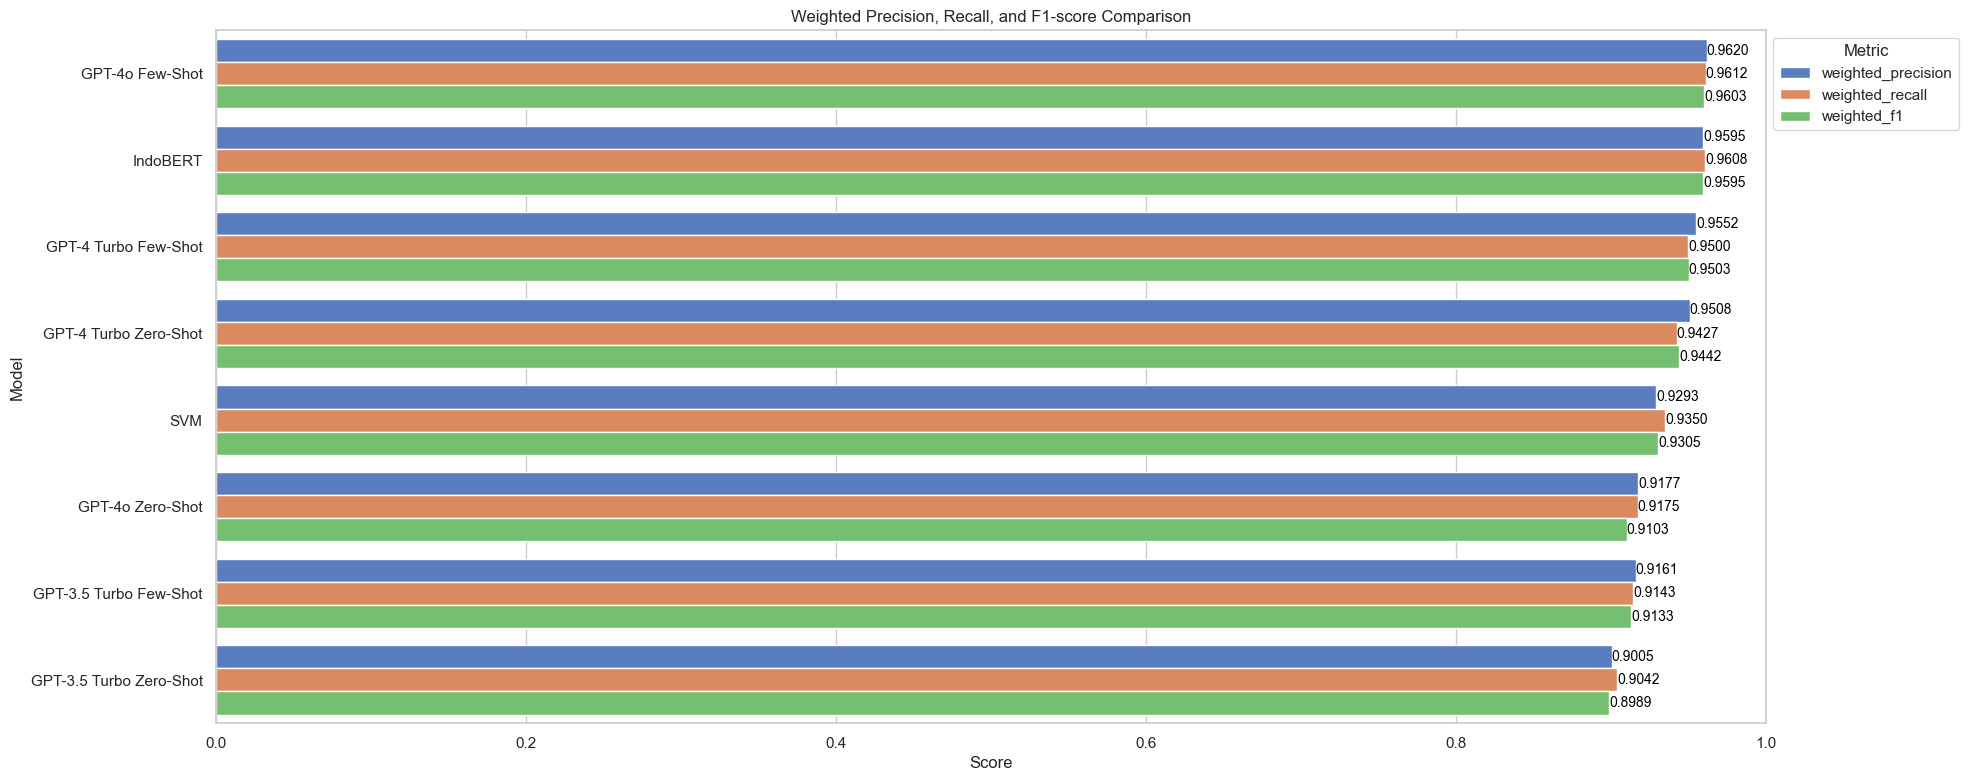

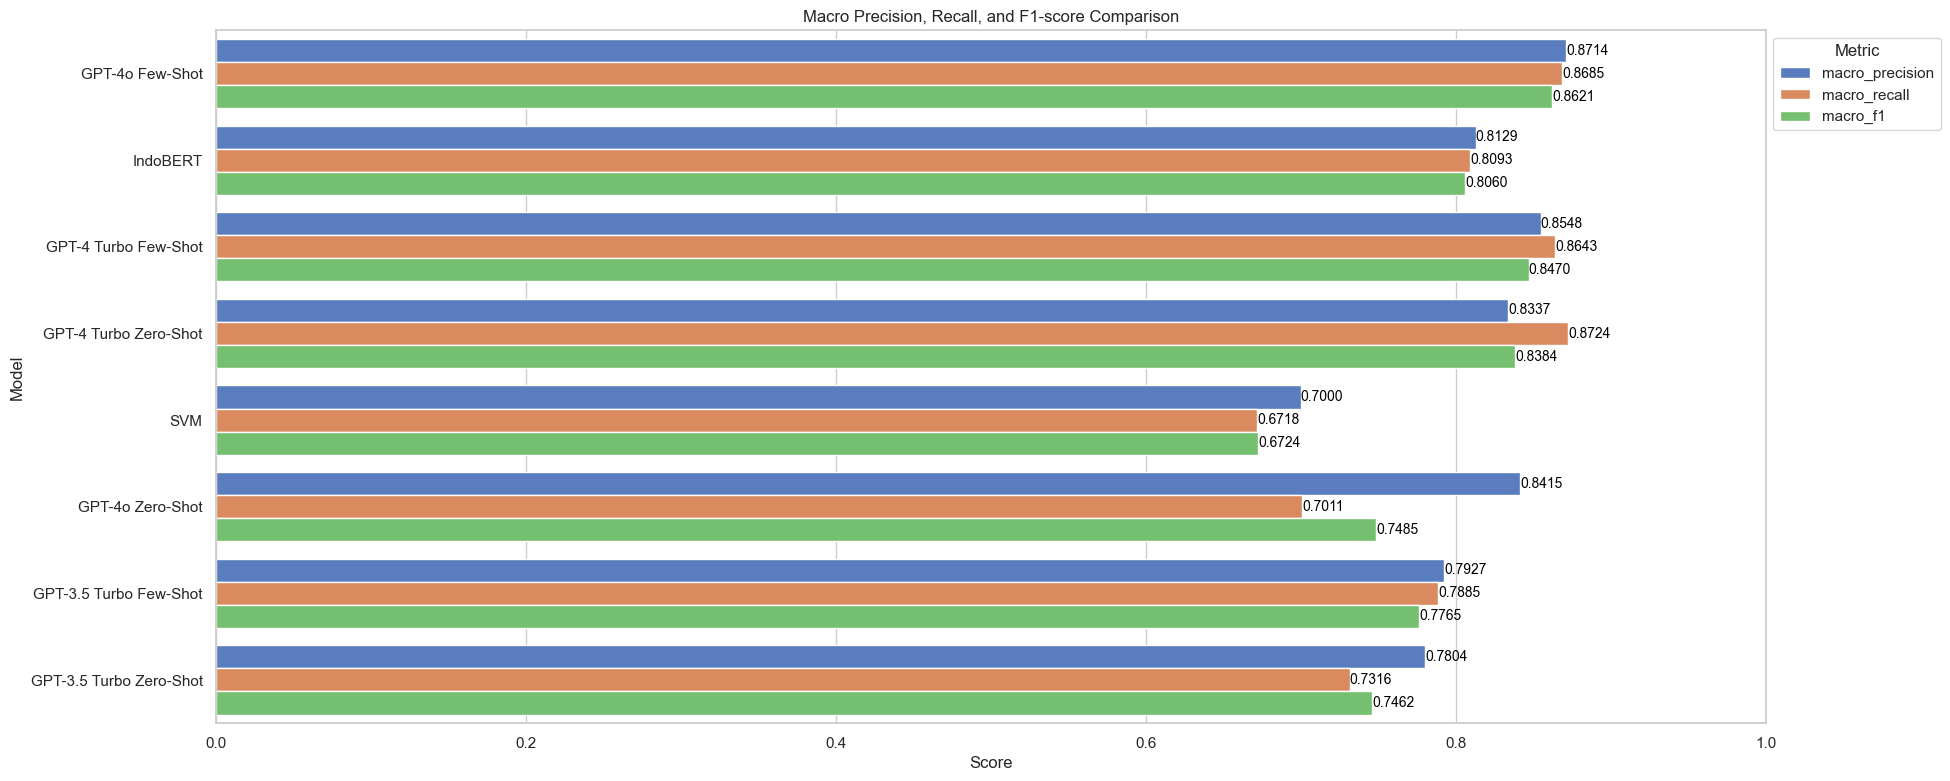

In [226]:
def add_value_labels(ax, decimal_places=4):
    """Adds value labels to bars in a barplot, skipping zeros."""
    for p in ax.patches:
        if p.get_width() > 0: 
            ax.annotate(f'{p.get_width():.{decimal_places}f}',
                        (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', fontsize=10, color='black')

# First plot: Weighted metrics
metrics = ["weighted_precision", "weighted_recall", "weighted_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Weighted Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Second plot: Macro metrics
metrics = ["macro_precision", "macro_recall", "macro_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Macro Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [227]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # Display the DataFrame
# display(aspect_performance)

# # Reset to default after displaying
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')